# Bayesian Multinomial Regression

This notebook is an introductory tutorial to Bayesian multinomial regression with `RxInfer`.

In [1]:
using RxInfer, Plots, StableRNGs, Distributions, ExponentialFamily, StatsPlots
import ExponentialFamily: softmax 


## Model Description
The key innovation in Linderman et al. (2015) is extending the Pólya-gamma augmentation scheme to the multinomial case. This allows us to transform the non-conjugate multinomial likelihood into a conditionally conjugate form by introducing auxiliary Pólya-gamma random variables.

The multinomial regression model with Pólya-gamma augmentation can be written as:
$p(y | \psi, N) = \text{Multinomial}(y |N, \psi)$

where:
- $y$ is a $K$-dimensional vector of count data with $N$ total counts
- $\psi$ is a $K-1$ -dimensional Gaussian random variable

## Implementation

In this notebook, we will implement the Pólya-gamma augmented Bayesian multinomial regression model with `RxInfer` by performing inference using message passing to estimate the posterior distribution of the regression coefficients


In [2]:
function generate_multinomial_data(rng=StableRNG(123);N = 20, k=9, nsamples = 1000)
    Ψ = randn(rng, k)
    p = softmax(Ψ)
    X = rand(rng, Multinomial(N, p), nsamples)
    X= [X[:,i] for i in 1:size(X,2)];
    return X, Ψ,p
end

generate_multinomial_data (generic function with 2 methods)

In [3]:
nsamples = 5000
N = 30
k = 40
X, Ψ, p = generate_multinomial_data(N=N,k=k,nsamples=nsamples);

The `MultinomialPolya` factor node is used to model the likelihood of the multinomial distribution. 

Due to non-conjugacy of the likelihood and the prior distribution, we need to use a more complex inference algorithm. RxInfer provides an Expectation Propagation (EP) [2] algorithm to infer the posterior distribution. Due to EP's approximation, we need to specify an inbound message for the regression coefficients while using the `MultinomialPolya` factor node. This feature is implemented in the `dependencies` keyword argument during the creation of the `MultinomialPolya` factor node. `ReactiveMP.jl` provides a `RequireMessageFunctionalDependencies` type that is used to specify the inbound message for the regression coefficients `ψ`. Refer to the ReactiveMP.jl documentation for more information.

In [4]:
@model function multinomial_model(obs, N, ξ_ψ, W_ψ)
    ψ ~ MvNormalWeightedMeanPrecision(ξ_ψ, W_ψ)
    obs .~ MultinomialPolya(N, ψ) where {dependencies = RequireMessageFunctionalDependencies(ψ = MvNormalWeightedMeanPrecision(ξ_ψ, W_ψ))}
end

In [5]:
result = infer(
    model = multinomial_model(ξ_ψ=zeros(k-1), W_ψ=rand(Wishart(3, diageye(k-1))), N=N),
    data = (obs=X, ),
    iterations = 50,
    free_energy = true,
    showprogress = true,
    options = (
        limit_stack_depth = 100,
    )
)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


Inference results:
  Posteriors       | available for (ψ)
  Free Energy:     | Real[4.4635e5, 2.92458e5, 2.37907e5, 2.12174e5, 1.98084e5, 1.89611e5, 1.84171e5, 1.80505e5, 1.7794e5, 1.76092e5  …  1.69534e5, 1.69527e5, 1.69521e5, 1.69515e5, 1.6951e5, 1.69506e5, 1.69502e5, 1.69498e5, 1.69495e5, 1.69492e5]


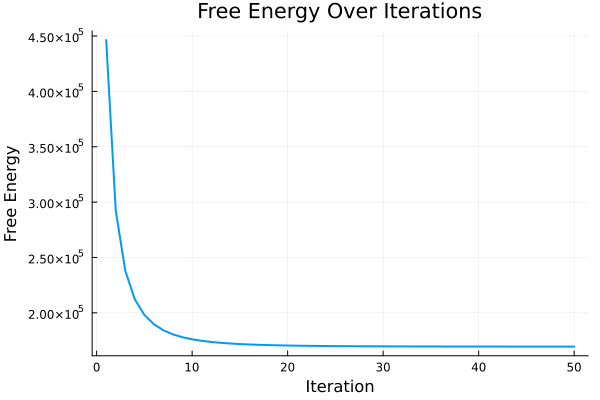

In [6]:
plot(result.free_energy[1:end], 
     title="Free Energy Over Iterations",
     xlabel="Iteration",
     ylabel="Free Energy",
     linewidth=2,
     legend=false,
     grid=true,
     )

In [7]:
predictive = @call_rule MultinomialPolya(:x, Marginalisation) (q_N = PointMass(N), q_ψ = result.posteriors[:ψ][end], meta = MultinomialPolyaMeta(21))
println("Estimated data generation probabilities: $(predictive.p)")
println("True data generation probabilities: $(p)")

Estimated data generation probabilities: [0.012143171073269848, 0.027544602651807394, 0.004712854397708326, 0.012799372263641615, 0.013663793174502436, 0.037462046309689134, 0.0076252103436249535, 0.0068724075371409355, 0.005657760798724058, 0.00407272650935273, 0.005379456795265574, 0.0039006796682530577, 0.004139490048274604, 0.036207971424904534, 0.108921049762374, 0.07263502120432333, 0.02626804228214761, 0.02408047460559856, 0.01025496077487289, 0.008851768118537008, 0.03978005605409956, 0.004828975454330443, 0.008471901792273273, 0.026520711828048667, 0.006299166729648266, 0.008105344938059622, 0.009064111916762716, 0.0070871411099272235, 0.017277116096988305, 0.007310435455733736, 0.008607342734727923, 0.004081912821927846, 0.011237881526012308, 0.010418960022828895, 0.09506895129390917, 0.04389406368939189, 0.13263969046133223, 0.027533649502951126, 0.03066505534106494, 0.06791467148596891]
True data generation probabilities: [0.012475572764691344, 0.027591159563011523, 0.00403

In [8]:
mse = mean((predictive.p - p).^2);
println("MSE between estimated and true data generation probabilities: $mse")

MSE between estimated and true data generation probabilities: 2.04362233834372e-7


In [9]:
@model function multinomial_regression(obs, N, X, ϕ, ξβ, Wβ)
    β ~ MvNormalWeightedMeanPrecision(ξβ, Wβ)
    for i in eachindex(obs)
        Ψ[i] := ϕ(X[i])*β
        obs[i] ~ MultinomialPolya(N, Ψ[i]) where {dependencies = RequireMessageFunctionalDependencies(ψ = MvNormalWeightedMeanPrecision(zeros(length(obs[i])-1), diageye(length(obs[i])-1)))}
    end
end


In [10]:
function generate_regression_data(rng=StableRNG(123);ϕ = identity,N = 3, k=5, nsamples = 1000)
    β = randn(rng, k)
    X = randn(rng, nsamples, k, k)
    X = [X[i,:,:] for i in 1:size(X,1)];
    Ψ = ϕ.(X)
    p = map(x -> logistic_stick_breaking(x*β), Ψ)
    return map(x -> rand(rng, Multinomial(N, x)), p), X, β, p
end


generate_regression_data (generic function with 2 methods)

In [11]:
ϕ = x -> sin(x)
obs_regression, X_regression, β_regression, p_regression = generate_regression_data(;nsamples = 5000, ϕ = ϕ);

In [12]:
reg_results = infer(  
    model = multinomial_regression(N = 3, ϕ = ϕ, ξβ = zeros(5), Wβ = rand(Wishart(5, diageye(5)))),
    data = (obs=obs_regression,X = X_regression ),
    iterations = 20,
    free_energy = true,
    showprogress = true,
    returnvars = KeepLast(),
    options = (
        limit_stack_depth = 100,
    ) 
)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


Inference results:
  Posteriors       | available for (Ψ, β)
  Free Energy:     | Real[11948.0, 11581.5, 11499.0, 11478.0, 11472.3, 11470.7, 11470.3, 11470.1, 11470.1, 11470.1, 11470.1, 11470.1, 11470.1, 11470.1, 11470.1, 11470.1, 11470.1, 11470.1, 11470.1, 11470.1]


In [13]:
println("estimated β: with mean and covariance: $(mean_cov(reg_results.posteriors[:β]))")
println("true β: $(β_regression)")

estimated β: with mean and covariance: ([-0.1148185195488236, 0.6633320736658673, -1.2546329066686652, -0.08580207814995357, -0.07945415190694004], [0.00014787949146768004 -2.0620837895552e-6 3.688897691476797e-6 -1.4950910055732714e-6 3.099557403103613e-6; -2.0620837895552e-6 0.00015166890641897098 -1.9368080247334776e-5 -3.5127854245836374e-7 1.3863981232947832e-6; 3.688897691476797e-6 -1.9368080247334776e-5 0.0001797714643072483 4.459304054461933e-6 4.953489097748698e-7; -1.4950910055732714e-6 -3.5127854245836374e-7 4.459304054461933e-6 0.00013999223647195576 3.2582461542129105e-6; 3.099557403103613e-6 1.3863981232947832e-6 4.953489097748698e-7 3.2582461542129105e-6 0.00013947284859108208])
true β: [-0.12683768965424458, 0.6668851724871252, -1.2566124895590247, -0.08499562516549662, -0.094274004848194]


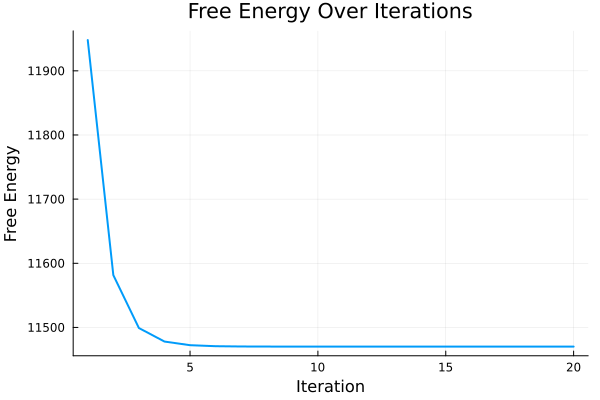

In [14]:
plot(reg_results.free_energy,
title="Free Energy Over Iterations",
xlabel="Iteration",
ylabel="Free Energy",
linewidth=2,
legend=false,
grid=true,)

In [15]:
mse_β =  mean((mean(reg_results.posteriors[:β]) - β_regression).^2)
println("MSE of β estimate: $mse_β")

MSE of β estimate: 7.625642345860117e-5


We can visualize how the logistic stick-breaking transformation of the simplex coordinates of the regression coefficients affects the prior distribution of the regression coefficients and vice versa since the logistic stick-breaking transformation is invertible.

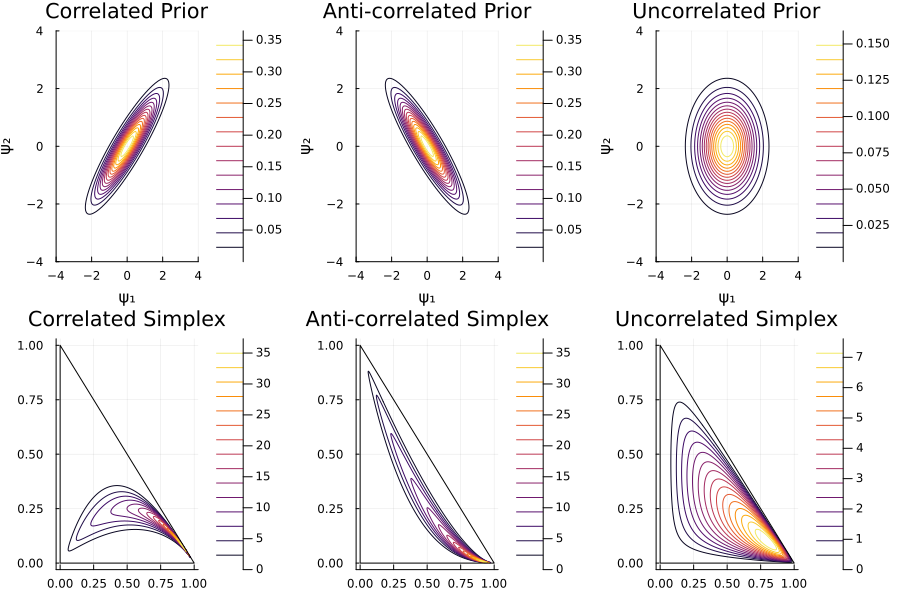

In [16]:

# Previous helper functions remain the same
σ(x) = 1 / (1 + exp(-x))
σ_inv(x) = log(x / (1 - x))

function jacobian_det(π)
    K = length(π)
    det = 1.0
    for k in 1:(K-1)
        num = 1 - sum(π[1:(k-1)])
        den = π[k] * (1 - sum(π[1:k]))
        det *= num / den
    end
    return det
end

function ψ_to_π(ψ::Vector{Float64})
    K = length(ψ) + 1
    π = zeros(K)
    for k in 1:(K-1)
        π[k] = σ(ψ[k]) * (1 - sum(π[1:(k-1)]))
    end
    π[K] = 1 - sum(π[1:(K-1)])
    return π
end

function π_to_ψ(π)
    K = length(π)
    ψ = zeros(K-1)
    ψ[1] = σ_inv(π[1])
    for k in 2:(K-1)
        ψ[k] = σ_inv(π[k] / (1 - sum(π[1:(k-1)])))
    end
    return ψ
end

# Function to compute density in simplex coordinates
function compute_simplex_density(x::Float64, y::Float64, Σ::Matrix{Float64})
    # Check if point is inside triangle
    if y < 0 || y > 1 || x < 0 || x > 1 || (x + y) > 1
        return 0.0
    end
    
    # Convert from simplex coordinates to π
    π1 = x
    π2 = y
    π3 = 1 - x - y
    
    try
        ψ = π_to_ψ([π1, π2, π3])
        # Compute Gaussian density
        dist = MvNormal(zeros(2), Σ)
        return pdf(dist, ψ) * abs(jacobian_det([π1, π2, π3]))
    catch
        return 0.0
    end
   
end

function plot_transformed_densities()
    # Create three different covariance matrices
    ###For higher variances values needs scaling for proper visualization.
    σ² = 1.0
    Σ_corr = [σ² 0.9σ²; 0.9σ² σ²]
    Σ_anticorr = [σ² -0.9σ²; -0.9σ² σ²]
    Σ_uncorr = [σ² 0.0; 0.0 σ²]
    
    # Plot Gaussian densities
    ψ1, ψ2 = range(-4sqrt(σ²), 4sqrt(σ²), length=500), range(-4sqrt(σ²), 4sqrt(σ²), length=100)
    
    p1 = contour(ψ1, ψ2, (x,y) -> pdf(MvNormal(zeros(2), Σ_corr), [x,y]),
                 title="Correlated Prior", xlabel="ψ₁", ylabel="ψ₂")
    p2 = contour(ψ1, ψ2, (x,y) -> pdf(MvNormal(zeros(2), Σ_anticorr), [x,y]),
                 title="Anti-correlated Prior", xlabel="ψ₁", ylabel="ψ₂")
    p3 = contour(ψ1, ψ2, (x,y) -> pdf(MvNormal(zeros(2), Σ_uncorr), [x,y]),
                 title="Uncorrelated Prior", xlabel="ψ₁", ylabel="ψ₂")
    
    # Plot simplex densities
    n_points = 500
    x = range(0, 1, length=n_points)
    y = range(0, 1, length=n_points)
    
    # Plot simplices
    p4 = contour(x, y, (x,y) -> compute_simplex_density(x, y, Σ_corr),
                 title="Correlated Simplex")
    
    # Add simplex boundaries and median lines
    plot!(p4, [0,1,0,0], [0,0,1,0], color=:black, label="")  # Triangle boundaries
    
    p5 = contour(x, y, (x,y) -> compute_simplex_density(x, y, Σ_anticorr),
                 title="Anti-correlated Simplex")
    plot!(p5, [0,1,0,0], [0,0,1,0], color=:black, label="")
    
    p6 = contour(x, y, (x,y) -> compute_simplex_density(x, y, Σ_uncorr),
                 title="Uncorrelated Simplex")
    plot!(p6, [0,1,0,0], [0,0,1,0], color=:black, label="")
    
    # Combine all plots
    plot(p1, p2, p3, p4, p5, p6, layout=(2,3), size=(900,600))
end

# Generate the plots
plot_transformed_densities()